# **IMPORTING LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats.mstats import winsorize
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from google.colab import drive

# **IMPORT DATASETS**

In [ ]:
drive.mount('/content/drive')
# Loading Datasets
longitudinal_df=pd.read_csv('/content/drive/MyDrive/oasis_longitudinal.csv')
cross_sectional_df = pd.read_csv('/content/drive/MyDrive/oasis_cross-sectional.csv')

# **MERGING DATASETS**

In [ ]:
# Merging Datasets
df = pd.merge(cross_sectional_df, longitudinal_df,how='outer')
df.head(5)

# **DROPPING IRRELEVANT COLUMNS**

In [ ]:
# Dropping Irrelevant Columns
df.drop(['Subject ID', 'MRI ID', 'ID', 'Hand', 'Visit', 'MR Delay', 'Delay', 'Educ'], axis=1, inplace=True)
df.head()

# **DATASET OVERVIEW**

In [ ]:
# Dataset Overview
df.info()
df.describe()
df.head()

# **MISSING VALUES**

In [ ]:
df.isnull().sum()

# **HANDLING MISSING VALUES**

In [ ]:
# Imputing missing values with median
df['SES'].fillna(df['SES'].median(), inplace=True)
df['MMSE'].fillna(df['MMSE'].median(), inplace=True)
df['CDR'].fillna(df['CDR'].median(), inplace=True)
df['EDUC'].fillna(df['EDUC'].median(), inplace=True)

df.isnull().sum()

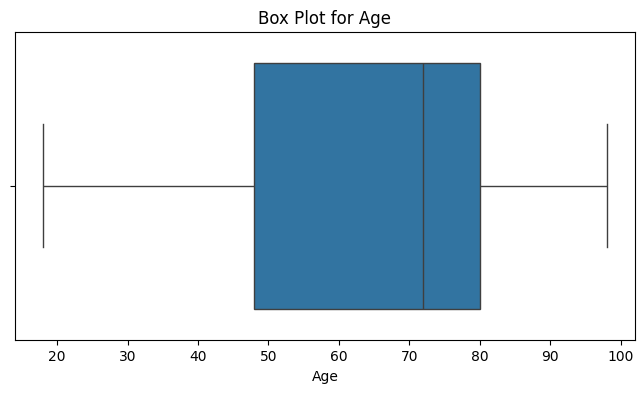

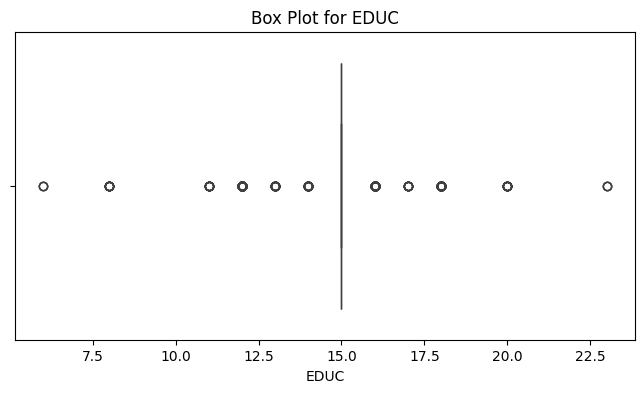

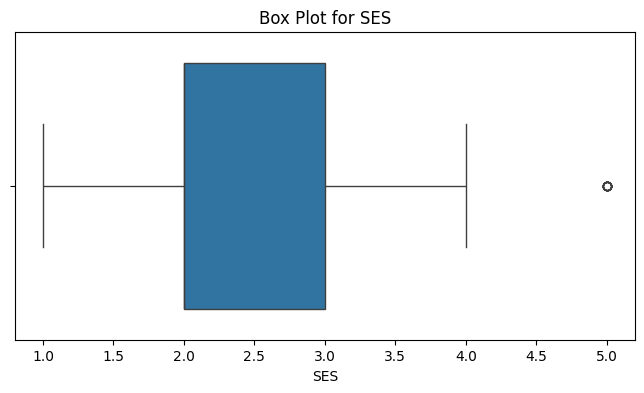

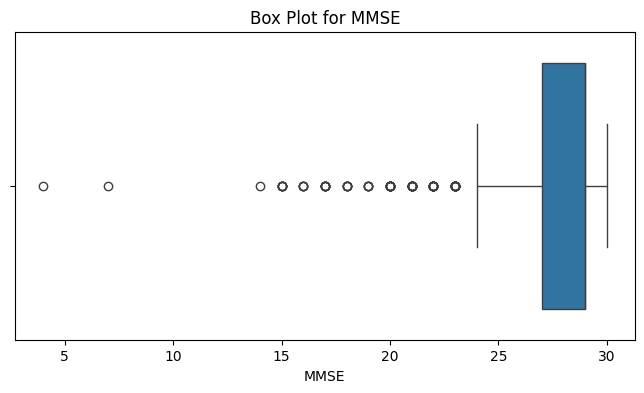

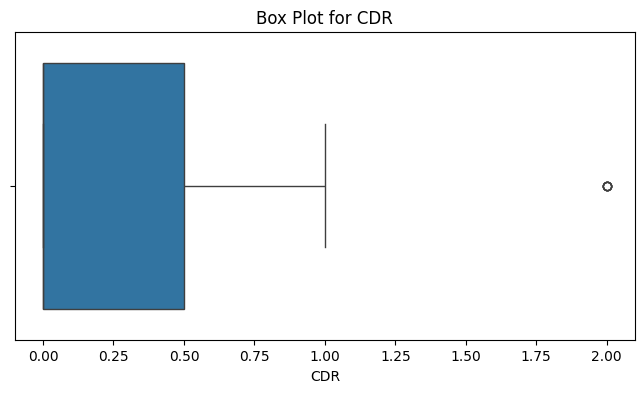

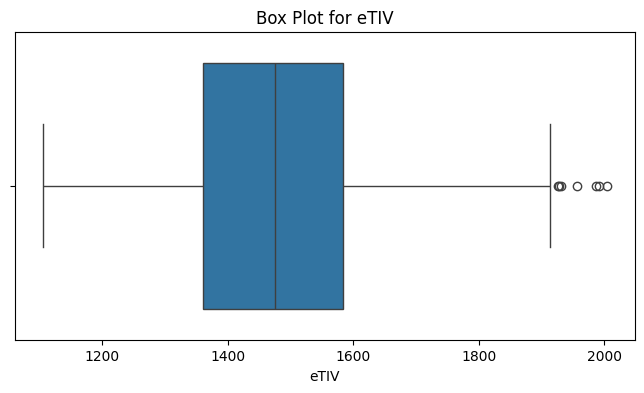

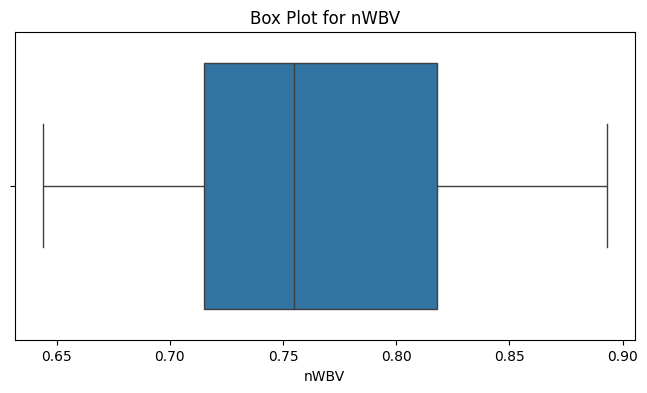

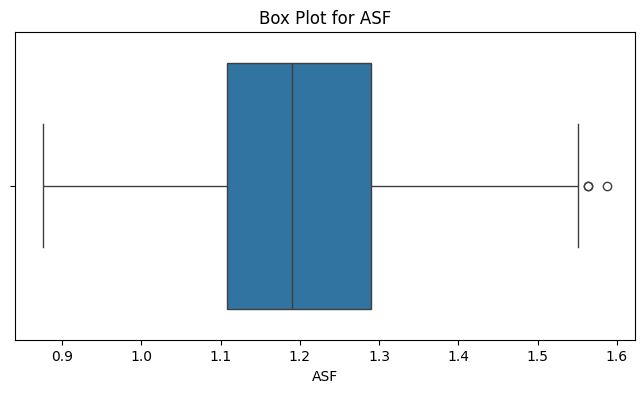

In [8]:
# Ploting box plots to visualize outliers
numeric_columns = ['Age','EDUC','SES', 'MMSE', 'CDR', 'eTIV', 'nWBV','ASF']
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot for {column}')
    plt.show()

In [9]:
# Capping outliers using IQR method
for column in ['EDUC','SES', 'MMSE', 'CDR', 'eTIV', 'ASF']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)


# **CONVERTING CATEGORICAL COLUMNS INTO NUMERICAL**

In [ ]:
# Converting Gender column into Numerical
df['Gender'] = df['M/F'].replace({'F': 0, 'M': 1})
df.drop(['M/F'], axis=1, inplace=True)
df['Gender'] = df['Gender'].replace('M',1)
df['Gender'] = df['Gender'].replace('F',0)
df.head(10)

In [ ]:
# Converting Group column into Numerical
df['Group'] = df['Group'].replace('Converted', 'Demented')
df['Group'].replace({'Nondemented': 0, 'Demented': 1}, inplace=True)
df['Group'].value_counts()

# **CORRELATION MATRIX**

In [ ]:
# Visualization of Correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# **IMPUTING MISSING VALUES OF TARGET COLUMN (GROUP) BY PREDICTIVE MODEL**

In [13]:
# Rows where Group is NOT missing
df_not_missing = df[df['Group'].notna()]
col_not_missing = df_not_missing[['CDR', 'MMSE', 'nWBV', 'Age', 'eTIV']]  # Features
target_not_missing = df_not_missing['Group']  # Target

# Rows where Group is missing
df_missing = df[df['Group'].isna()]
col_missing = df_missing[['CDR', 'MMSE', 'nWBV', 'Age', 'eTIV']]  # Features


In [ ]:
rf = RandomForestClassifier()
rf.fit(col_not_missing, target_not_missing)

# Predict missing values
df.loc[df['Group'].isna(), 'Group'] = rf.predict(col_missing)

# Check class balance if Group is categorical
print(df['Group'].value_counts())

# **GENDER DISTRIBUTION IN DEMENTIA & NON-DEMENTIA GROUP**

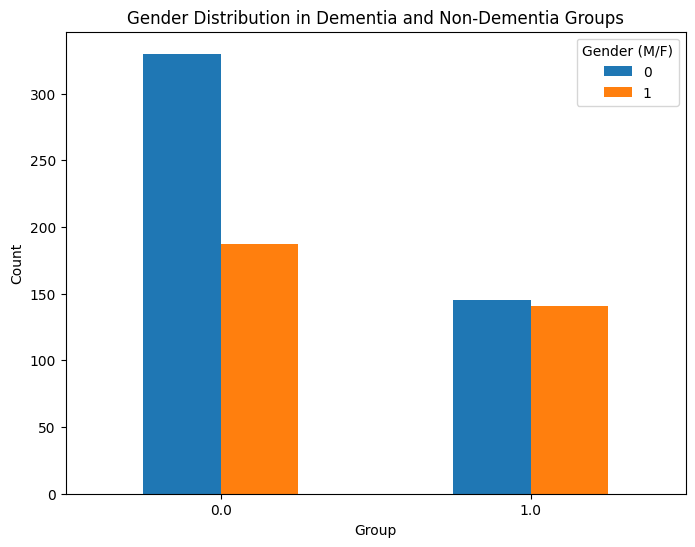

In [15]:
# Gender and Dementia/Alzheimer's Disease
df_gender = df.groupby(['Group', 'Gender']).size().unstack()
df_gender.plot(kind='bar', figsize=(8, 6))
plt.title("Gender Distribution in Dementia and Non-Dementia Groups")
plt.xlabel("Group")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Gender (M/F)")
plt.show()

# **EDUCATION VS. GROUP**

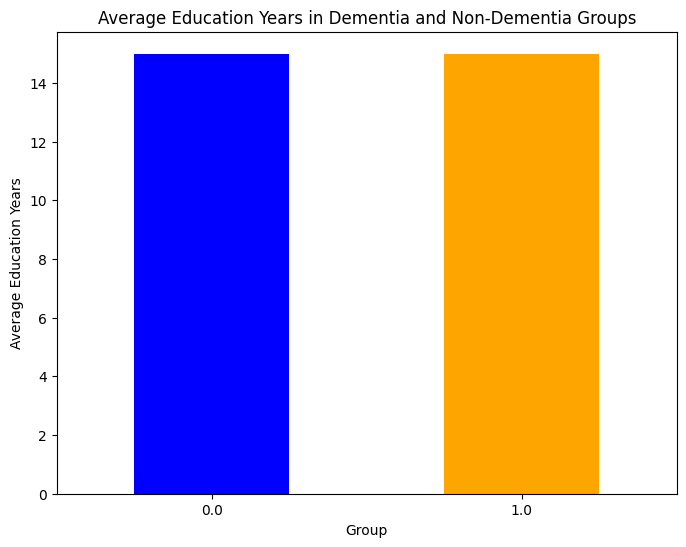

In [16]:
# Education and Dementia
df_education = df.groupby('Group')['EDUC'].mean()
df_education.plot(kind='bar', figsize=(8, 6), color=['blue', 'orange'])
plt.title("Average Education Years in Dementia and Non-Dementia Groups")
plt.xlabel("Group")
plt.ylabel("Average Education Years")
plt.xticks(rotation=0)
plt.show()

# **AVERAGE BRAIN VOLUME (nWBV) in GROUP**

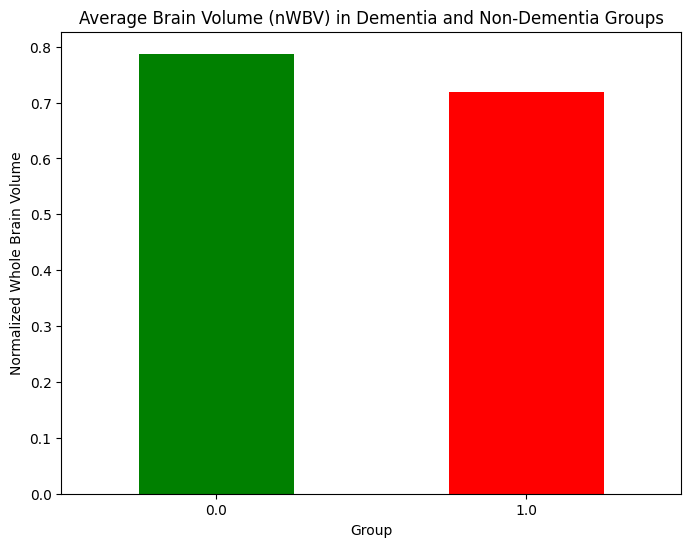

In [17]:
#Brain Volume and Dementia
df_brain_volume = df.groupby('Group')['nWBV'].mean()
df_brain_volume.plot(kind='bar', figsize=(8, 6), color=['green', 'red'])
plt.title("Average Brain Volume (nWBV) in Dementia and Non-Dementia Groups")
plt.xlabel("Group")
plt.ylabel("Normalized Whole Brain Volume")
plt.xticks(rotation=0)
plt.show()

# **AGE DISTRIBUTION IN GROUP**

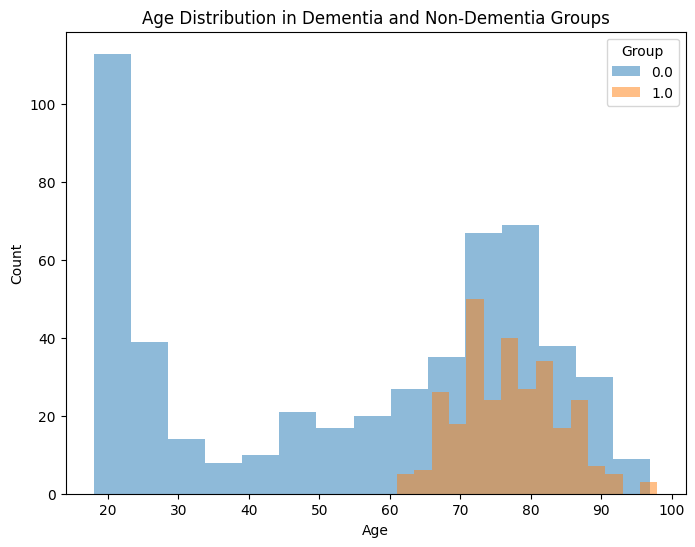

In [18]:
# Age Distribution in Dementia
plt.figure(figsize=(8, 6))
for group in df['Group'].unique():
    subset = df[df['Group'] == group]
    plt.hist(subset['Age'], alpha=0.5, label=group, bins=15)

plt.title("Age Distribution in Dementia and Non-Dementia Groups")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend(title="Group")
plt.show()

# **DATASET OVERVIEW**

In [19]:
df.info()
df.describe()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     803 non-null    int64  
 1   SES     803 non-null    float64
 2   MMSE    803 non-null    float64
 3   CDR     803 non-null    float64
 4   eTIV    803 non-null    int64  
 5   nWBV    803 non-null    float64
 6   ASF     803 non-null    float64
 7   Group   803 non-null    float64
 8   EDUC    803 non-null    float64
 9   Gender  803 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 62.9 KB


(803, 10)

# **SEPERATING FEATURES FROM TARGET**

In [20]:
X=df.drop('Group',axis=1)
y=df['Group']

# **SELECT KBEST TECHNIQUE**

In [ ]:
select_kbest = SelectKBest(score_func=f_classif, k=6)
X_selected = select_kbest.fit_transform(X, y)

# Get the mask of selected features and their corresponding scores
selected_features_mask = select_kbest.get_support()
selected_features = X.columns[selected_features_mask]
selected_scores = select_kbest.scores_[selected_features_mask]

# Create a DataFrame for selected features and their scores
selected_feature_scores = pd.DataFrame({
    'Feature': selected_features,
    'Score': selected_scores
}).sort_values(by='Score', ascending=False)

# Display selected features and their scores
print(selected_feature_scores)

# Visualize the selected features and their scores
plt.figure(figsize=(8, 5))
plt.bar(selected_feature_scores['Feature'], selected_feature_scores['Score'], color='skyblue')
plt.xlabel("Selected Features")
plt.ylabel("Scores")
plt.title(f"Top 6 Features Selected by SelectKBest")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **Synthetic Minority Over-Sampling Technique (SMOTE)**

In [ ]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X_selected, y)

y.value_counts()
X.shape
y.shape

# **SPLITTING THE DATASET**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify =y)

# **SCALING FEATURES USING STANDARD SCALER**

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape
X_test_scaled.shape

# **IMPLEMENTING GAUSSIAN NAIVE BAYES (GNB)**

Gaussian Naive Bayes Accuracy: 0.94
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       104
         1.0       0.94      0.94      0.94       103

    accuracy                           0.94       207
   macro avg       0.94      0.94      0.94       207
weighted avg       0.94      0.94      0.94       207


10-Fold Cross-Validation Accuracy Scores:
[0.95180723 0.93975904 0.95180723 0.96385542 0.92771084 0.95180723
 0.96385542 0.97560976 0.96341463 0.97560976]

Mean Accuracy: 0.9565
Standard Deviation of Accuracy: 0.0144


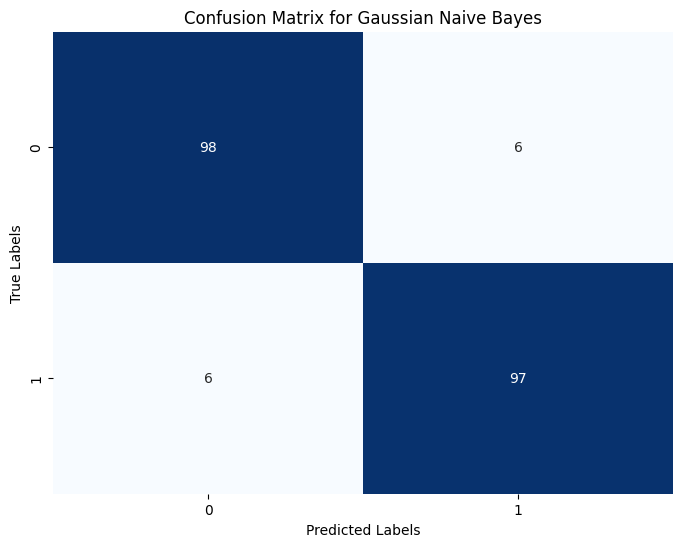

In [25]:
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
gnb_pred = gnb.predict(X_test_scaled)
gnb_acc = accuracy_score(y_test, gnb_pred)
print(f"Gaussian Naive Bayes Accuracy: {gnb_acc:.2f}")
print(classification_report(y_test, gnb_pred))

# Perform 10-Fold Cross-Validation
scores = cross_val_score(gnb, X_train_scaled, y_train, cv=10, scoring='accuracy')

print("\n10-Fold Cross-Validation Accuracy Scores:")
print(scores)
print("\nMean Accuracy: {:.4f}".format(scores.mean()))
print("Standard Deviation of Accuracy: {:.4f}".format(scores.std()))

cm = confusion_matrix(y_test, gnb_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Gaussian Naive Bayes')
plt.show()

# **IMPLEMENTING DECISION TREE (DT)**

Decision Tree Accuracy: 0.97
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       104
         1.0       0.98      0.96      0.97       103

    accuracy                           0.97       207
   macro avg       0.97      0.97      0.97       207
weighted avg       0.97      0.97      0.97       207


10-Fold Cross-Validation Accuracy Scores:
[0.96385542 0.97590361 0.91566265 0.98795181 0.97590361 0.97590361
 0.96385542 0.98780488 0.96341463 0.96341463]

Mean Accuracy: 0.9674
Standard Deviation of Accuracy: 0.0195


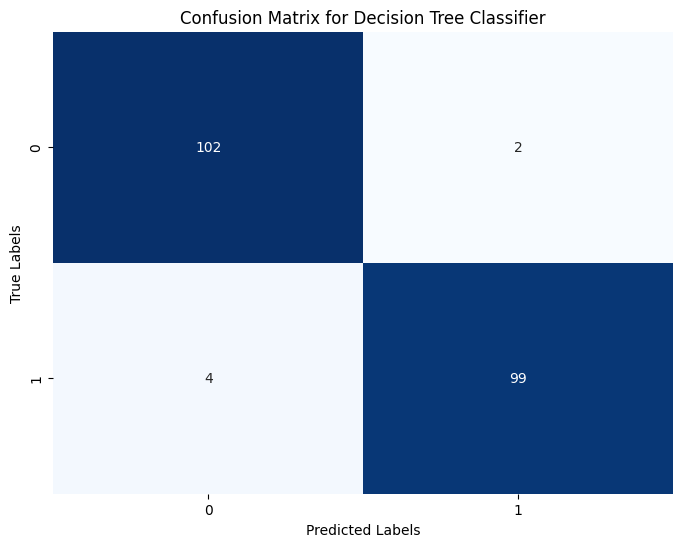

In [26]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=2, random_state=42)
dt.fit(X_train_scaled, y_train)
dt_pred = dt.predict(X_test_scaled)
dt_acc = accuracy_score(y_test, dt_pred)
print(f"Decision Tree Accuracy: {dt_acc:.2f}")
print(classification_report(y_test, dt_pred))

# Cross-Validation
scores = cross_val_score(dt, X_train_scaled, y_train, cv=10, scoring='accuracy')

print("\n10-Fold Cross-Validation Accuracy Scores:")
print(scores)
print("\nMean Accuracy: {:.4f}".format(scores.mean()))
print("Standard Deviation of Accuracy: {:.4f}".format(scores.std()))

cm = confusion_matrix(y_test, dt_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

# **IMPLEMENTING RANDOM FOREST CLASSIFIER (RF)**

Random Forest Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       104
         1.0       0.99      0.96      0.98       103

    accuracy                           0.98       207
   macro avg       0.98      0.98      0.98       207
weighted avg       0.98      0.98      0.98       207


10-Fold Cross-Validation Accuracy Scores:
[0.96385542 0.96385542 0.96385542 1.         0.93975904 0.97590361
 0.98795181 0.98780488 0.96341463 0.96341463]

Mean Accuracy: 0.9710
Standard Deviation of Accuracy: 0.0164


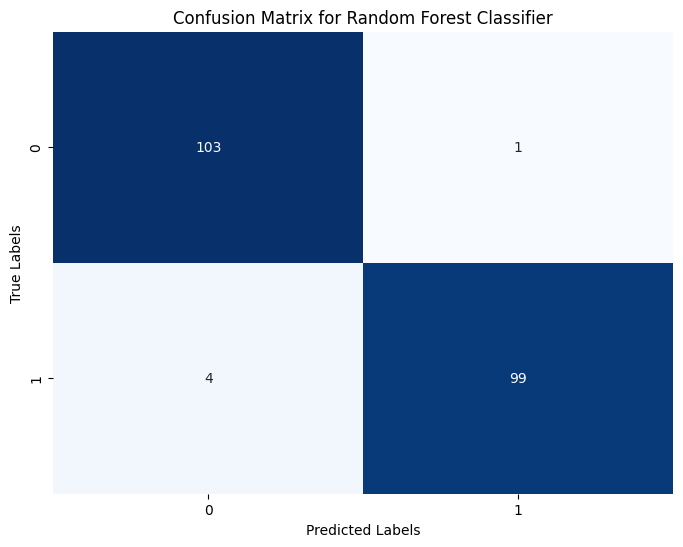

In [27]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42, n_jobs=-1)

'''rf=RandomForestClassifier()'''
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

# Cross-Validation
scores = cross_val_score(rf, X_train_scaled, y_train, cv=10, scoring='accuracy')

print("\n10-Fold Cross-Validation Accuracy Scores:")
print(scores)
print("\nMean Accuracy: {:.4f}".format(scores.mean()))
print("Standard Deviation of Accuracy: {:.4f}".format(scores.std()))

cm = confusion_matrix(y_test, rf_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

# **IMPLEMENTING GRADIENT BOOSTING (GB)**

Gradient Boosting Accuracy: 0.97

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       104
         1.0       0.98      0.96      0.97       103

    accuracy                           0.97       207
   macro avg       0.97      0.97      0.97       207
weighted avg       0.97      0.97      0.97       207


10-Fold Cross-Validation Accuracy Scores:
[0.96385542 0.96385542 0.93975904 1.         0.96385542 0.97590361
 0.96385542 0.98780488 0.93902439 0.98780488]

Mean Accuracy: 0.9686
Standard Deviation of Accuracy: 0.0189


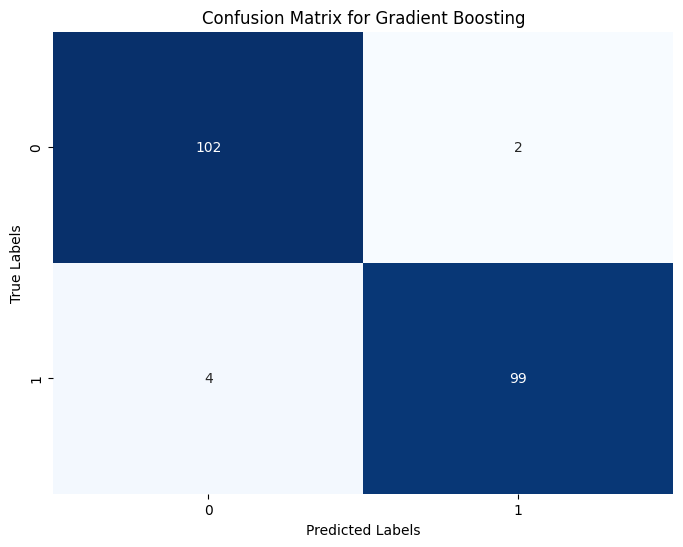

In [28]:
gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)

'''gb = GradientBoostingClassifier()'''
gb.fit(X_train_scaled, y_train)
gb_pred = gb.predict(X_test_scaled)
gb_acc = accuracy_score(y_test, gb_pred)
print(f"Gradient Boosting Accuracy: {gb_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, gb_pred))

# Cross-Validation
scores = cross_val_score(gb, X_train_scaled, y_train, cv=10, scoring='accuracy')

print("\n10-Fold Cross-Validation Accuracy Scores:")
print(scores)
print("\nMean Accuracy: {:.4f}".format(scores.mean()))
print("Standard Deviation of Accuracy: {:.4f}".format(scores.std()))

cm = confusion_matrix(y_test, gb_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Gradient Boosting')
plt.show()

# **IMPLEMENTING EXTREME GRADIENT BOOSTING CLASSIFIER (XGB)**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.98
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       104
         1.0       0.99      0.96      0.98       103

    accuracy                           0.98       207
   macro avg       0.98      0.98      0.98       207
weighted avg       0.98      0.98      0.98       207



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


10-Fold Cross-Validation Accuracy Scores:
[0.96385542 0.96385542 0.92771084 1.         0.96385542 0.97590361
 0.96385542 0.98780488 0.96341463 0.98780488]

Mean Accuracy: 0.9698
Standard Deviation of Accuracy: 0.0188


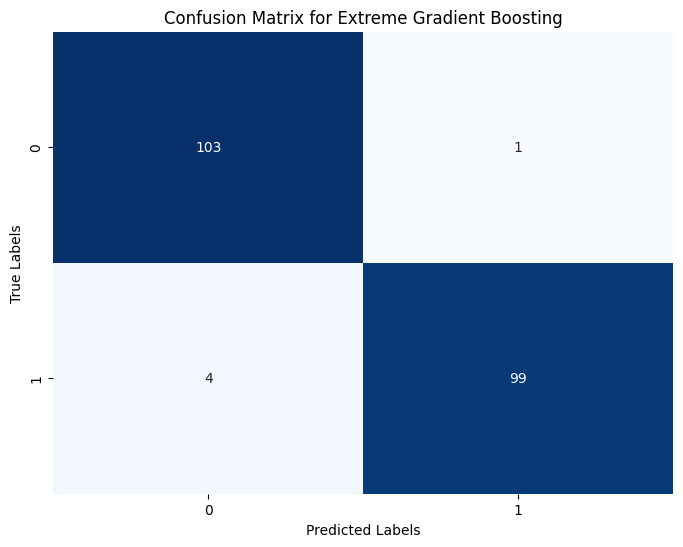

In [29]:
xgb = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42, use_label_encoder=False, n_jobs=-1)

'''xgb= XGBClassifier()'''
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)
xgb_acc = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Accuracy: {xgb_acc:.2f}")
print(classification_report(y_test, xgb_pred))

# Cross-Validation
scores = cross_val_score(xgb, X_train_scaled, y_train, cv=10, scoring='accuracy')

print("\n10-Fold Cross-Validation Accuracy Scores:")
print(scores)

print("\nMean Accuracy: {:.4f}".format(scores.mean()))
print("Standard Deviation of Accuracy: {:.4f}".format(scores.std()))

cm = confusion_matrix(y_test, xgb_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Extreme Gradient Boosting')
plt.show()

# **IMPLEMENTING VOTING CLASSIFIER (VT)**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Voting Classifier Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       104
         1.0       0.99      0.96      0.98       103

    accuracy                           0.98       207
   macro avg       0.98      0.98      0.98       207
weighted avg       0.98      0.98      0.98       207



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


10-Fold Cross-Validation Accuracy Scores:
[0.96385542 0.96385542 0.93975904 1.         0.95180723 0.97590361
 0.97590361 0.98780488 0.96341463 0.98780488]

Mean Accuracy: 0.9710
Standard Deviation of Accuracy: 0.0172


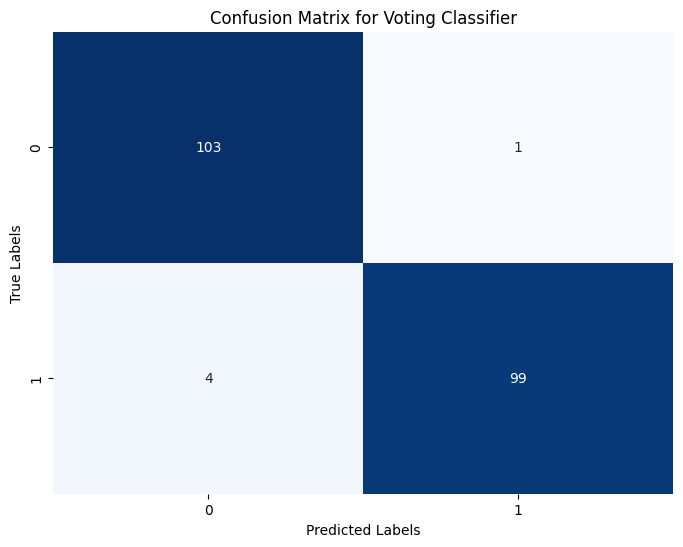

In [30]:
vt=VotingClassifier(estimators=[('gnb', gnb), ('dt', dt), ('xgb', xgb), ('rf', rf), ('gb', gb)], voting='soft')
vt.fit(X_train_scaled, y_train)
vt_pred = vt.predict(X_test_scaled)
vt_acc = accuracy_score(y_test, vt_pred)
print(f"Voting Classifier Accuracy: {vt_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, vt_pred))
# Cross-Validation
scores = cross_val_score(vt, X_train_scaled, y_train, cv=10, scoring='accuracy')

print("\n10-Fold Cross-Validation Accuracy Scores:")
print(scores)

print("\nMean Accuracy: {:.4f}".format(scores.mean()))
print("Standard Deviation of Accuracy: {:.4f}".format(scores.std()))

cm = confusion_matrix(y_test, vt_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Voting Classifier')
plt.show()

# **GENERALIZATION ANALYSIS BASED ON ACCURACY**

In [ ]:
# Accuracies
gnb_train_acc = accuracy_score(y_train, gnb.predict(X_train_scaled))
gnb_test_acc = accuracy_score(y_test, gnb.predict(X_test_scaled))
print(f"Gaussian Naive Bayes Training Accuracy: {gnb_train_acc:.3f}")
print(f"Gaussian Naive Bayes Test Accuracy: {gnb_test_acc:.3f}")

# Errors
gnb_train_error = 1 - gnb_train_acc
gnb_test_error = 1 - gnb_test_acc
print(f"Gaussian Naive Bayes Training Error: {gnb_train_error:.4f}")
print(f"Gaussian Naive Bayes Testing Error: {gnb_test_error:.4f}")

In [ ]:
# Accuracies
dt_train_acc = accuracy_score(y_train, dt.predict(X_train_scaled))
dt_test_acc = accuracy_score(y_test, dt.predict(X_test_scaled))
print(f"Decision Tree Training Accuracy: {dt_train_acc:.3f}")
print(f"Decision Tree Test Accuracy: {dt_test_acc:.3f}")

# Errors
dt_train_error = 1 - dt_train_acc
dt_test_error = 1 - dt_test_acc
print(f"Decision Tree Training Error: {dt_train_error:.4f}")
print(f"Decision Tree Testing Error: {dt_test_error:.4f}")

In [ ]:
# Accuracies
rf_train_acc = accuracy_score(y_train, rf.predict(X_train_scaled))
rf_test_acc = accuracy_score(y_test, rf.predict(X_test_scaled))
print(f"Random Forest Training Accuracy: {rf_train_acc:.3f}")
print(f"Random Forest Test Accuracy: {rf_test_acc:.3f}")

# Errors
rf_train_error = 1 - rf_train_acc
rf_test_error = 1 - rf_test_acc
print(f"Random Forest Training Error: {rf_train_error:.4f}")
print(f"Random Forest Testing Error: {rf_test_error:.4f}")

In [ ]:
# Accuracies
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_scaled))
gb_test_acc = accuracy_score(y_test, gb.predict(X_test_scaled))
print(f"Gradient Boosting Training Accuracy: {gb_train_acc:.3f}")
print(f"Gradient Boosting Test Accuracy: {gb_test_acc:.3f}")

# Errors
gb_train_error = 1 - gb_train_acc
gb_test_error = 1 - gb_test_acc
print(f"Gradient Boosting Training Error: {gb_train_error:.4f}")
print(f"Gradient Boosting Testing Error: {gb_test_error:.4f}")

In [ ]:
# Accuracies
xgb_train_acc = accuracy_score(y_train, xgb.predict(X_train_scaled))
xgb_test_acc = accuracy_score(y_test, xgb.predict(X_test_scaled))
print(f"Extreme Gradient Boosting Training Accuracy: {xgb_train_acc:.3f}")
print(f"Extreme Gradient Boosting Test Accuracy: {xgb_test_acc:.3f}")

# Errors
xgb_train_error = 1 - xgb_train_acc
xgb_test_error = 1 - xgb_test_acc
print(f"Extreme Gradient Boosting Training Error: {xgb_train_error:.4f}")
print(f"Extreme Gradient Boosting Testing Error: {xgb_test_error:.4f}")

In [ ]:
# Accuracies
vt_train_acc = accuracy_score(y_train, vt.predict(X_train_scaled))
vt_test_acc = accuracy_score(y_test, vt.predict(X_test_scaled))
print(f"Voting Classifier Training Accuracy: {vt_train_acc:.3f}")
print(f"Voting Classifier Test Accuracy: {vt_test_acc:.3f}")

# Errors
vt_train_error = 1 - vt_train_acc
vt_test_error = 1 - vt_test_acc
print(f"Voting Classifier Training Error: {vt_train_error:.4f}")
print(f"Voting Classifier Testing Error: {vt_test_error:.4f}")

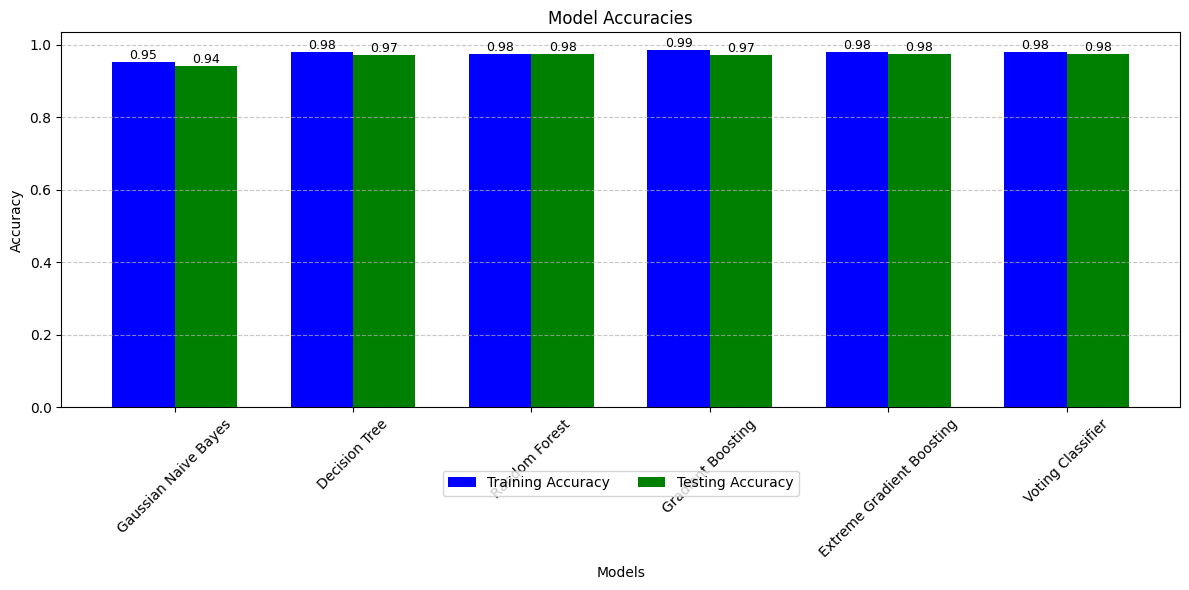

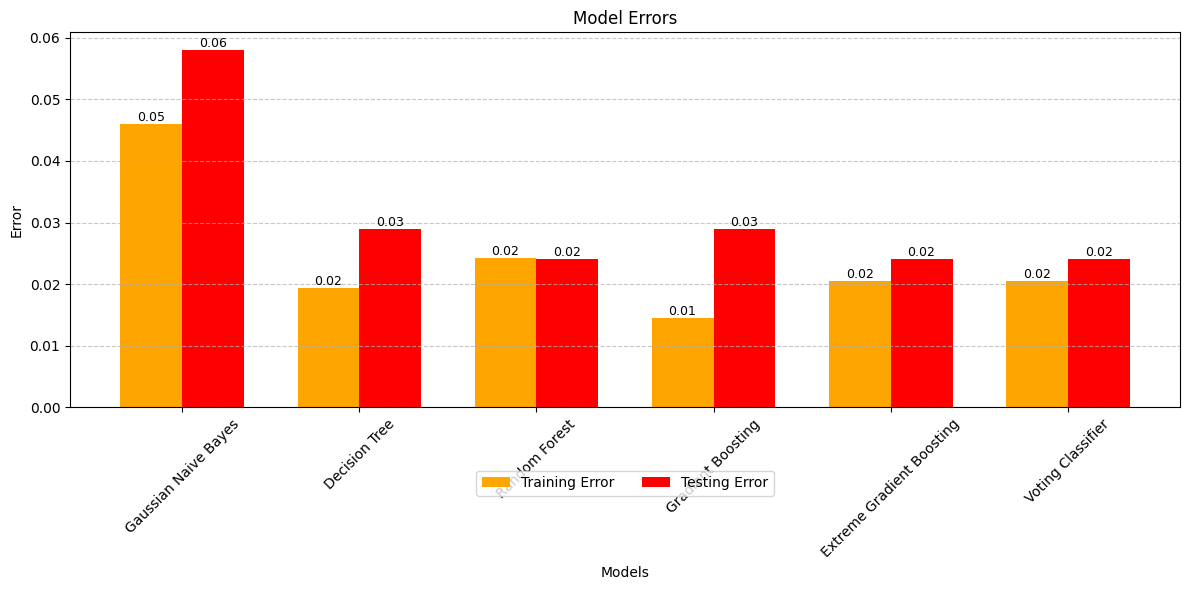

In [37]:
# Model Names
models = ['Gaussian Naive Bayes', 'Decision Tree', 'Random Forest',
          'Gradient Boosting', 'Extreme Gradient Boosting', 'Voting Classifier']

# Accuracies
train_accuracies = [gnb_train_acc, dt_train_acc, rf_train_acc, gb_train_acc, xgb_train_acc, vt_train_acc]
test_accuracies = [gnb_test_acc, dt_test_acc, rf_test_acc, gb_test_acc, xgb_test_acc, vt_test_acc]

# Errors
train_errors = [gnb_train_error, dt_train_error, rf_train_error, gb_train_error, xgb_train_error, vt_train_error]
test_errors = [gnb_test_error, dt_test_error, rf_test_error, gb_test_error, xgb_test_error, vt_test_error]

# Bar Width and Indices
bar_width = 0.35
index = np.arange(len(models))

# Function to Add Values on Bars
def add_values_on_bars(ax, bars):
    """Add values on top of bars."""
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Plot for Accuracies
fig, ax = plt.subplots(figsize=(12, 6))
train_bars = ax.bar(index - bar_width / 2, train_accuracies, bar_width, label='Training Accuracy', color='blue')
test_bars = ax.bar(index + bar_width / 2, test_accuracies, bar_width, label='Testing Accuracy', color='green')
add_values_on_bars(ax, train_bars)
add_values_on_bars(ax, test_bars)
ax.set_title('Model Accuracies')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot for Errors
fig, ax = plt.subplots(figsize=(12, 6))
train_bars = ax.bar(index - bar_width / 2, train_errors, bar_width, label='Training Error', color='orange')
test_bars = ax.bar(index + bar_width / 2, test_errors, bar_width, label='Testing Error', color='red')
add_values_on_bars(ax, train_bars)
add_values_on_bars(ax, test_bars)
ax.set_title('Model Errors')
ax.set_xlabel('Models')
ax.set_ylabel('Error')
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()